In [1]:
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = Path("../../")

# --- Read accounts.tsv ---
accounts_path = DATA_DIR / "accounts.tsv"
accounts_df = pd.read_csv(
    accounts_path,
    sep="\t",
    dtype=str,            # keep IDs as strings
    keep_default_na=False # avoid NaN for empty fields
)

# Standardize column names
accounts_df.columns = [c.strip() for c in accounts_df.columns]
if "author_id" not in accounts_df.columns:
    for alt in ["id", "user_id", "account_id"]:
        if alt in accounts_df.columns:
            accounts_df = accounts_df.rename(columns={alt: "author_id"})
            break

print("=== accounts.tsv ===")
print(accounts_df.head())
print(accounts_df["Type"].value_counts())

=== accounts.tsv ===
             author_id                 Type Lang Stance
0              8508262  Private individuals   fr    For
1           3297659759      Advocacy actors   es    For
2  1351436889316683778  Journalistic actors   en    For
3            259352661      Advocacy actors   en    For
4             17158610      Advocacy actors   en    For
Type
Advocacy actors        632
Political actors       310
Journalistic actors    271
Business actors        241
Private individuals    227
Unclear                142
Scientific actors       90
                         9
Other                    9
Bots                     4
to-do                    1
Name: count, dtype: int64


In [3]:
tweets_path = DATA_DIR / "tweets.dat"

def parse_tweets(path, max_rows=None):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            try:
                obj = json.loads(line)
                rows.append({
                    "id": obj.get("id"),
                    "author_id": obj.get("author_id"),
                    "text": obj.get("text"),
                    "created_at": obj.get("created_at"),
                    "lang": obj.get("lang"),
                    "referenced_tweets": obj.get("referenced_tweets"),
                    "public_metrics": obj.get("public_metrics"),

                    "attachments": obj.get("attachments"),
                    "entities": obj.get("entities"),
                })
            except Exception as e:
                # skip malformed lines
                continue
    return pd.DataFrame(rows)

# --- Read tweets.dat ---
tweets_df = parse_tweets(tweets_path, max_rows=None)
print("Parsed tweets:", len(tweets_df))
tweets_df.head()

Parsed tweets: 2260916


,id,author_id,text,created_at,lang,referenced_tweets,public_metrics,attachments,entities
0,675827469119832066,1011975294,RT @MinisterTdB: Climate change won’t stop ove...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757779674700390...","{'retweet_count': 107, 'reply_count': 0, 'like...",None,"{'mentions': [{'start': 3, 'end': 15, 'usernam..."
1,675827469006581760,255144027,RT @LaurenceTubiana: I just can believe it !we...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757815547450572...","{'retweet_count': 109, 'reply_count': 0, 'like...",None,"{'mentions': [{'start': 3, 'end': 19, 'usernam..."
2,675827468775718912,214748274,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T23:59:59.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",{'media_keys': ['3_675748710089940992']},"{'mentions': [{'start': 3, 'end': 11, 'usernam..."
3,675827465378504705,449273927,RT @TheGlobalGoals: Incredible news for our wo...,2015-12-12T23:59:58.000Z,en,"[{'type': 'retweeted', 'id': '6757646325990440...","{'retweet_count': 110, 'reply_count': 0, 'like...",None,"{'mentions': [{'start': 3, 'end': 18, 'usernam..."
4,675827465336434688,1601937732,RT @StopShenhua: “The people’s resolve is such...,2015-12-12T23:59:58.000Z,en,"[{'type': 'retweeted', 'id': '6757735596884541...","{'retweet_count': 49, 'reply_count': 0, 'like_...",None,"{'mentions': [{'start': 3, 'end': 15, 'usernam..."


## Similar groups

### Data preparation

In [4]:
groups_df = pd.read_csv("image_groups_sample_with_tweet.csv")
groups_df.head()

,image_file,group_id,tweet_id
0,3_675668070577348608.jpg,0,675787732753514498
1,3_675668070577348608.jpg,0,675739705812586497
2,3_675668070577348608.jpg,0,675714635786543106
3,3_675668070577348608.jpg,0,675695521550442497
4,3_675668070577348608.jpg,0,675695457906139136


In [8]:
groups_df['group_id'].value_counts()

group_id
2794    1137
909      912
310      811
1315     432
3037     431
        ... 
2188       1
2189       1
2191       1
2192       1
4469       1
Name: count, Length: 4470, dtype: int64

In [21]:
selected_images = groups_df[groups_df['group_id'] == 909]
selected_images.head()

,image_file,group_id,tweet_id
7070,3_675748710089940992.jpg,909,675827468775718912
7071,3_675748710089940992.jpg,909,675827316480745472
7072,3_675748710089940992.jpg,909,675825874806116352
7073,3_675748710089940992.jpg,909,675825842769932290
7074,3_675748710089940992.jpg,909,675825309690671104


In [ ]:
selected_images['tweet_id'] = selected_images['tweet_id'].astype(str)
merged_df = selected_images.merge(
    tweets_df, 
    left_on="tweet_id",  
    right_on="id",     
    how="inner"      
).merge(
    accounts_df,
    on="author_id",
    how="inner")
merged_df = merged_df.drop(columns=["id"])

C:\Users\Highway\AppData\Local\Temp\ipykernel_280868\272927705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_images['tweet_id'] = selected_images['tweet_id'].astype(str)


In [43]:
def is_retweet(ref):
    if isinstance(ref, list) and len(ref) > 0:
        return any(r.get("type") == "retweeted" for r in ref)
    return False

merged_df["is_retweet"] = merged_df["referenced_tweets"].apply(is_retweet)

In [56]:
def get_metrics(ref, metric):
    if isinstance(ref, dict):
        return ref.get(metric)
    return None

merged_df["retweet_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "retweet_count"))
merged_df["reply_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "reply_count"))
merged_df["like_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "like_count"))
merged_df["quote_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "quote_count"))


In [68]:
merged_df.head()

,image_file,group_id,tweet_id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,retweet_count,reply_count,like_count,quote_count
0,3_675748710089940992.jpg,909,675808920665849857,369338525,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T22:46:17.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Business actors,en,For,True,1204,0,0,0
1,3_675748710089940992.jpg,909,675779227606753280,2625963400,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T20:48:17.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Business actors,en,For,True,1204,0,0,0
2,3_675748710089940992.jpg,909,675775631578238976,237244779,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T20:34:00.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Private individuals,en,For,True,1204,0,0,0
3,3_675748710089940992.jpg,909,675762763789152257,57322373,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T19:42:52.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Advocacy actors,fr,For,True,1204,0,0,0
4,3_675748710089940992.jpg,909,675762514643259392,40955185,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T19:41:53.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Advocacy actors,en,For,True,1204,0,0,0


In [49]:
merged_df.iloc[0]['public_metrics']

{'retweet_count': 1204, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}

### Temporal Dynamics

In [25]:
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
group_timeline = merged_df.groupby(merged_df['created_at'].dt.date).size()


<Axes: title={'center': 'Tweet Timeline for Image Group 909'}, xlabel='created_at'>

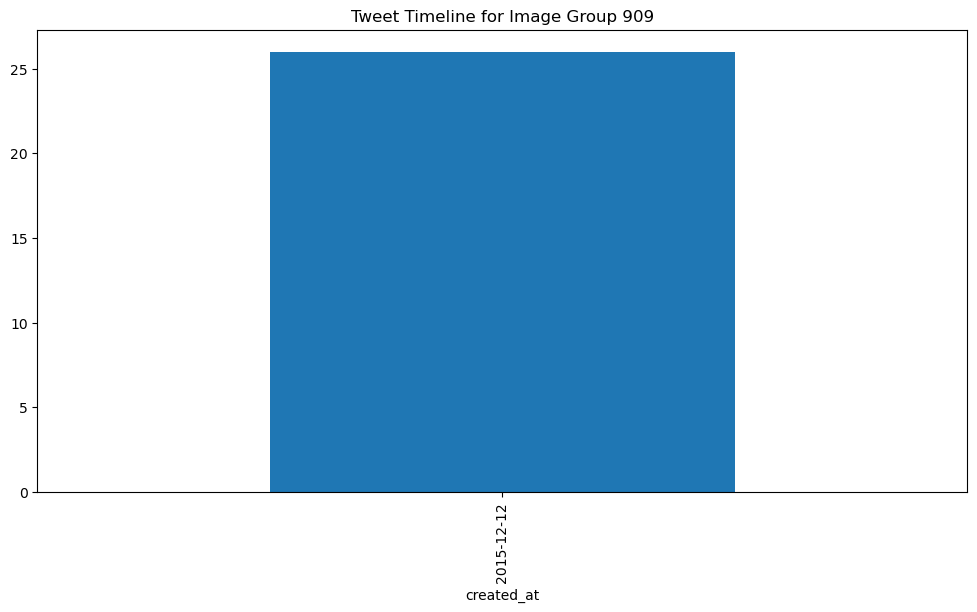

In [27]:
group_timeline.plot(kind='bar', figsize=(12, 6), title='Tweet Timeline for Image Group 909')

Created date is all the same!

### Spreading / Retweets

In [ ]:
merged_df['referenced_tweets']

In [36]:
merged_df['is_retweet'].value_counts()

is_retweet
True     20
False     6
Name: count, dtype: int64

### Account Types

In [46]:
merged_df['Type'].value_counts()

Type
Political actors       8
Advocacy actors        6
Private individuals    5
Business actors        4
Journalistic actors    2
Unclear                1
Name: count, dtype: int64

### Engagement

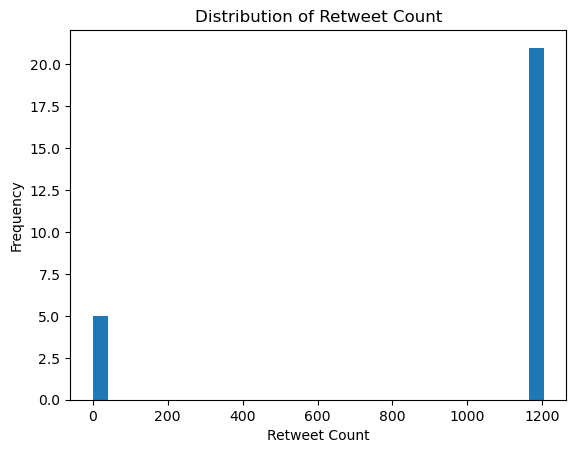

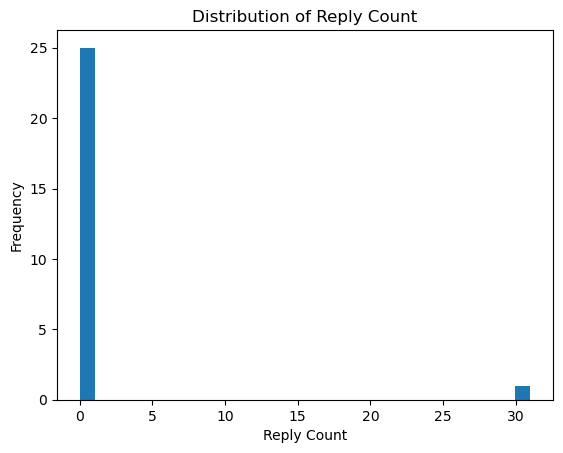

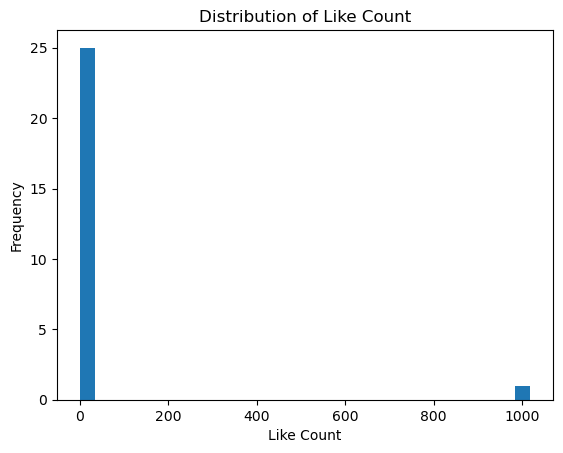

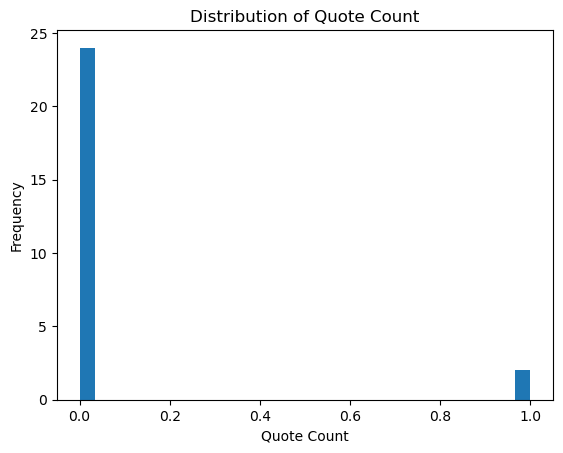

In [62]:
for metric in ["retweet_count", "reply_count", "like_count", "quote_count"]:
    plt.hist(merged_df[metric], bins=30)
    plt.title(f"Distribution of {metric.replace('_', ' ').title()}")
    plt.xlabel(metric.replace('_', ' ').title())
    plt.ylabel("Frequency")
    plt.show()

In [65]:
merged_df["public_metrics"].value_counts()

public_metrics
{'retweet_count': 1204, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}        20
{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}            3
{'retweet_count': 1204, 'reply_count': 31, 'like_count': 1019, 'quote_count': 1}     1
{'retweet_count': 3, 'reply_count': 0, 'like_count': 6, 'quote_count': 0}            1
{'retweet_count': 12, 'reply_count': 0, 'like_count': 13, 'quote_count': 1}          1
Name: count, dtype: int64

In [64]:
merged_df[merged_df['retweet_count'] == 1204]['Type'].value_counts()

Type
Political actors       7
Advocacy actors        6
Business actors        4
Private individuals    2
Unclear                1
Journalistic actors    1
Name: count, dtype: int64

In [66]:
merged_df[(merged_df['retweet_count'] == 1204) & (merged_df['reply_count'] != 0)]

,image_file,group_id,tweet_id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,retweet_count,reply_count,like_count,quote_count
22,3_675748710089940992.jpg,909,675748720244297729,4010449719,We did it! #ParisAgreement is adopted! #COP21 ...,2015-12-12T18:47:04.000Z,en,None,"{'retweet_count': 1204, 'reply_count': 31, 'li...",Political actors,en,Unclear,False,1204,31,1019,1


In [67]:
merged_df['text'].value_counts()

text
RT @COP21en: We did it! #ParisAgreement is adopted! #COP21 #GoCOP21 https://t.co/JGXsQkR6Fh                                                  20
thebteamhq: RT COP21en: We did it! #ParisAgreement is adopted! #COP21 #GoCOP21 https://t.co/fqBxdXCkaf                                        1
Success of Togetherness."@COP21en:We did it! #ParisAgreement is adopted! #COP21 #GoCOP21 https://t.co/BIhSV8LowV"                             1
We did it! #ParisAgreement is adopted! #COP21 #GoCOP21 https://t.co/JGXsQkR6Fh                                                                1
#Ambassades @FrenchEmbassyZA: Agreement adopted! #COP21 #ProudofFrance https://t.co/60UV31y3OE https://t.co/mBqfieSAmD                        1
Agreement adopted! #COP21 #ProudofFrance https://t.co/pOqzniRArS                                                                              1
#WeDidIt \nL'accord de Paris est un moment historique pour les peuples du monde entier : #FiersDuMonde ! \n#COP21 https://t.co/TYSI

In [69]:
merged_df['image_file'].value_counts()

image_file
3_675748710089940992.jpg    23
3_675776575766446080.jpg     2
3_675754163293298689.jpg     1
Name: count, dtype: int64

In [71]:
merged_df.sort_values(by="created_at")

,image_file,group_id,tweet_id,author_id,text,created_at,lang,referenced_tweets,public_metrics,Type,Lang,Stance,is_retweet,retweet_count,reply_count,like_count,quote_count
22,3_675748710089940992.jpg,909,675748720244297729,4010449719,We did it! #ParisAgreement is adopted! #COP21 ...,2015-12-12T18:47:04.000Z,en,None,"{'retweet_count': 1204, 'reply_count': 31, 'li...",Political actors,en,Unclear,False,1204,31,1019,1
21,3_675748710089940992.jpg,909,675749016848744449,2617471956,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:48:15.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Political actors,fr,Unclear,True,1204,0,0,0
20,3_675748710089940992.jpg,909,675749074272915456,2510820704,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:48:28.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Advocacy actors,en,For,True,1204,0,0,0
19,3_675748710089940992.jpg,909,675749082342772736,450481607,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:48:30.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Private individuals,fr,For,True,1204,0,0,0
18,3_675748710089940992.jpg,909,675749261171118081,312698496,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:49:13.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Business actors,en,For,True,1204,0,0,0
17,3_675748710089940992.jpg,909,675749449226846208,40001204,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:49:58.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Political actors,en,For,True,1204,0,0,0
16,3_675748710089940992.jpg,909,675749624477421569,1370626844,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:50:39.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Political actors,en,For,True,1204,0,0,0
15,3_675748710089940992.jpg,909,675750383491371008,21866534,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:53:40.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Advocacy actors,en,For,True,1204,0,0,0
14,3_675748710089940992.jpg,909,675750584318894080,96335206,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:54:28.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Advocacy actors,en,For,True,1204,0,0,0
13,3_675748710089940992.jpg,909,675751541152854016,223416400,RT @COP21en: We did it! #ParisAgreement is ado...,2015-12-12T18:58:16.000Z,en,"[{'type': 'retweeted', 'id': '6757487202442977...","{'retweet_count': 1204, 'reply_count': 0, 'lik...",Journalistic actors,en,For,True,1204,0,0,0


## Clusters

### Data preparation

In [5]:
part1_data = pd.read_csv("descriptions.tsv", sep="\t", dtype=str, keep_default_na=False)

In [6]:
part1_data

,Dir,ImageID,Labels
0,media,3_671671279821398016.jpg,The image conveys a sense of community and col...
1,media,3_674113133523415040.jpg,I'm unable to identify the individuals in the ...
2,media,3_673034418605322240.jpg,The image conveys a strong advocacy for nuclea...
3,media,3_671292051875602433.jpg,The image conveys a sense of global unity and ...
4,media,3_671366298241208320.jpg,The image conveys a sense of solidarity and co...
...,...,...,...
44432,media,3_675024335082508290.jpg,The image juxtaposes elements of darkness and ...
44433,media,3_671211155944284160.jpg,The image conveys a sense of collaboration and...
44434,media,3_671662619485450240.jpg,I can't identify the specific individuals in t...
44435,media,3_672433621274402816.jpg,The image likely conveys themes of collaborati...


In [7]:
clusters_df = groups_df.merge(
    part1_data[['ImageID', 'Labels']],
    left_on="image_file",
    right_on="ImageID",
    how="inner" 
)
clusters_df = clusters_df.drop(columns=["ImageID"])

In [10]:
clusters_df.head()

,image_file,group_id,tweet_id,Labels
0,3_675668070577348608.jpg,0,675787732753514498,The image conveys a strong sense of collective...
1,3_675668070577348608.jpg,0,675739705812586497,The image conveys a strong sense of collective...
2,3_675668070577348608.jpg,0,675714635786543106,The image conveys a strong sense of collective...
3,3_675668070577348608.jpg,0,675695521550442497,The image conveys a strong sense of collective...
4,3_675668070577348608.jpg,0,675695457906139136,The image conveys a strong sense of collective...


In [16]:
import re
import html
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
STOP = set(stopwords.words('english'))
STOP.update(['image']) 

# normalization regex
# url_re = re.compile(r"http\S+|www\.\S+")
# mention_re = re.compile(r"@\w+")
non_word_re = re.compile(r"[^a-z0-9#']+") # BTM: only keep words
clean_re = re.compile(r"[^a-zA-Z0-9#',.!?]+") # BERT: keep punctuation, remove special symbols


def preprocess_for_btm(text):
    if not isinstance(text, str): return []
    
    # text = url_re.sub(" ", text)
    # text = mention_re.sub(" ", text)
    text = non_word_re.sub(" ", text)
    
    tokens = []
    for t in text.split():
        t = t.strip("'")
        if (t not in STOP) and (len(t) > 2) and (not t.isdigit()):
            lemma = lemmatizer.lemmatize(t) 
            tokens.append(lemma)
            
    return tokens

clusters_df['tokens'] = clusters_df['Labels'].apply(preprocess_for_btm)

clusters_df = clusters_df[clusters_df['tokens'].map(len) > 0].copy()
clusters_df['text_btm_str'] = clusters_df['tokens'].apply(lambda x: " ".join(x))
clusters_df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Highway\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Highway\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,image_file,group_id,tweet_id,Labels,btm_topic,tokens,text_btm_str
0,3_675668070577348608.jpg,0,675787732753514498,The image conveys a strong sense of collective...,33,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
1,3_675668070577348608.jpg,0,675739705812586497,The image conveys a strong sense of collective...,33,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
2,3_675668070577348608.jpg,0,675714635786543106,The image conveys a strong sense of collective...,33,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
3,3_675668070577348608.jpg,0,675695521550442497,The image conveys a strong sense of collective...,33,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
4,3_675668070577348608.jpg,0,675695457906139136,The image conveys a strong sense of collective...,33,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...


In [17]:
import bitermplus as btm
BTM_K = 100  # number of topics

X, vocabulary, vocab_dict = btm.get_words_freqs(clusters_df['text_btm_str'].values)
docs_vec = btm.get_vectorized_docs(clusters_df['text_btm_str'].values, vocabulary)

# Biterms
biterms = btm.get_biterms(docs_vec)

# Train model
model_btm = btm.BTM(X, vocabulary, seed=42, T=BTM_K, M=20, alpha=50/BTM_K, beta=0.01)
model_btm.fit(biterms, iterations=20)

# View results
topics = model_btm.transform(docs_vec)
# Get top words
top_words = btm.get_top_topic_words(model_btm, words_num=10)
print(top_words)

# Store the most likely topic for each tweet
clusters_df['btm_topic'] = topics.argmax(axis=1)

100%|██████████| 29543/29543 [00:06<00:00, 4357.63it/s]

         topic0         topic1         topic2             topic3       topic4  \
0       climate        setting         region         industrial    ecosystem   
1        change         formal        climate      environmental         life   
2       urgency       presence      different          pollution       marine   
3         sense     discussion         change             impact  environment   
4        global       suggests        concern        consequence    intricate   
5   connotative       dialogue         merica  industrialization   symbolizes   
6         issue  collaboration     experience              human       within   
7       conveys     importance           atin             evokes      balance   
8       meaning     conference         across              smoke   importance   
9  highlighting         likely  environmental            climate       evokes   

          topic5       topic6         topic7        topic8       topic9  ...  \
0     expression      climat

In [18]:
clusters_df.head()

,image_file,group_id,tweet_id,Labels,btm_topic,tokens,text_btm_str
0,3_675668070577348608.jpg,0,675787732753514498,The image conveys a strong sense of collective...,37,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
1,3_675668070577348608.jpg,0,675739705812586497,The image conveys a strong sense of collective...,37,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
2,3_675668070577348608.jpg,0,675714635786543106,The image conveys a strong sense of collective...,37,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
3,3_675668070577348608.jpg,0,675695521550442497,The image conveys a strong sense of collective...,37,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...
4,3_675668070577348608.jpg,0,675695457906139136,The image conveys a strong sense of collective...,37,"[conveys, strong, sense, collective, action, u...",conveys strong sense collective action urgency...


In [19]:
clusters_df.to_csv("image_clusters_sample_with_btm_topics.csv", index=False)

In [20]:
clusters_df['btm_topic'].value_counts()

btm_topic
1     1675
34    1238
55    1138
66    1028
61     971
      ... 
81      10
88       7
36       5
90       3
89       2
Name: count, Length: 97, dtype: int64

In [22]:
selected_images = clusters_df[clusters_df['btm_topic'] == 66]
selected_images.head()

,image_file,group_id,tweet_id,Labels,btm_topic,tokens,text_btm_str
98,3_674959873440948224.jpg,9,674959876024594432,The image depicts a booth at an event focused ...,66,"[depicts, booth, event, focused, climate, issu...",depicts booth event focused climate issue sugg...
99,3_674235048955142144.jpg,9,674235050146324480,The image conveys themes of sustainability and...,66,"[conveys, theme, sustainability, innovation, p...",conveys theme sustainability innovation partic...
165,3_672116821466697728.jpg,22,672116821651267585,"The image juxtaposes renewable energy sources,...",66,"[juxtaposes, renewable, energy, source, repres...",juxtaposes renewable energy source represented...
483,3_671472789837090816.jpg,40,671472790739009537,The image conveys a sense of urgency and colla...,66,"[conveys, sense, urgency, collaboration, addre...",conveys sense urgency collaboration addressing...
533,3_674310192826224640.jpg,46,674310194952802305,The image evokes a strong connotation of advoc...,66,"[evokes, strong, connotation, advocacy, urgenc...",evokes strong connotation advocacy urgency ind...


In [23]:
selected_images['tweet_id'] = selected_images['tweet_id'].astype(str)
merged_df = selected_images.merge(
    tweets_df, 
    left_on="tweet_id",  
    right_on="id",     
    how="inner"      
).merge(
    accounts_df,
    on="author_id",
    how="inner")
merged_df = merged_df.drop(columns=["id"])
merged_df.head()

C:\Users\Highway\AppData\Local\Temp\ipykernel_21052\3415917537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_images['tweet_id'] = selected_images['tweet_id'].astype(str)


,image_file,group_id,tweet_id,Labels,btm_topic,tokens,text_btm_str,author_id,text,created_at,lang,referenced_tweets,public_metrics,attachments,entities,Type,Lang,Stance
0,3_674959873440948224.jpg,9,674959876024594432,The image depicts a booth at an event focused ...,66,"[depicts, booth, event, focused, climate, issu...",depicts booth event focused climate issue sugg...,2564846623,Come and visit our booth at the Blue Zone from...,2015-12-10T14:32:29.000Z,en,None,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","{'media_keys': ['3_674959874481135616', '3_674...","{'annotations': [{'start': 32, 'end': 40, 'pro...",Advocacy actors,en,For
1,3_674235048955142144.jpg,9,674235050146324480,The image conveys themes of sustainability and...,66,"[conveys, theme, sustainability, innovation, p...",conveys theme sustainability innovation partic...,2564846623,Come and visit our booth at the Blue Zone from...,2015-12-08T14:32:17.000Z,en,None,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","{'media_keys': ['3_674235048955142144', '3_674...","{'urls': [{'start': 107, 'end': 130, 'url': 'h...",Advocacy actors,en,For
2,3_672116821466697728.jpg,22,672116821651267585,"The image juxtaposes renewable energy sources,...",66,"[juxtaposes, renewable, energy, source, repres...",juxtaposes renewable energy source represented...,31887585,What You Need to Know About the #ParisClimateT...,2015-12-02T18:15:12.000Z,en,None,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",{'media_keys': ['3_672116821466697728']},"{'hashtags': [{'start': 32, 'end': 50, 'tag': ...",Advocacy actors,en,
3,3_671472789837090816.jpg,40,671472790739009537,The image conveys a sense of urgency and colla...,66,"[conveys, sense, urgency, collaboration, addre...",conveys sense urgency collaboration addressing...,255676193,Principio #6: Promover la vinculación internac...,2015-11-30T23:36:03.000Z,es,None,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",{'media_keys': ['3_671472789837090816']},"{'hashtags': [{'start': 108, 'end': 114, 'tag'...",Business actors,es,Unclear
4,3_674310192826224640.jpg,46,674310194952802305,The image evokes a strong connotation of advoc...,66,"[evokes, strong, connotation, advocacy, urgenc...",evokes strong connotation advocacy urgency ind...,217071937,We have to act now to address #climatechange.W...,2015-12-08T19:30:53.000Z,en,None,"{'retweet_count': 1, 'reply_count': 0, 'like_c...","{'media_keys': ['3_674310192826224640', '3_674...","{'hashtags': [{'start': 30, 'end': 44, 'tag': ...",Business actors,en,Unclear


In [26]:
len(merged_df)

296

In [24]:
def is_retweet(ref):
    if isinstance(ref, list) and len(ref) > 0:
        return any(r.get("type") == "retweeted" for r in ref)
    return False

merged_df["is_retweet"] = merged_df["referenced_tweets"].apply(is_retweet)

def get_metrics(ref, metric):
    if isinstance(ref, dict):
        return ref.get(metric)
    return None

merged_df["retweet_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "retweet_count"))
merged_df["reply_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "reply_count"))
merged_df["like_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "like_count"))
merged_df["quote_count"] = merged_df["public_metrics"].apply(lambda x: get_metrics(x, "quote_count"))
merged_df.head()

,image_file,group_id,tweet_id,Labels,btm_topic,tokens,text_btm_str,author_id,text,created_at,...,attachments,entities,Type,Lang,Stance,is_retweet,retweet_count,reply_count,like_count,quote_count
0,3_674959873440948224.jpg,9,674959876024594432,The image depicts a booth at an event focused ...,66,"[depicts, booth, event, focused, climate, issu...",depicts booth event focused climate issue sugg...,2564846623,Come and visit our booth at the Blue Zone from...,2015-12-10T14:32:29.000Z,...,"{'media_keys': ['3_674959874481135616', '3_674...","{'annotations': [{'start': 32, 'end': 40, 'pro...",Advocacy actors,en,For,False,1,0,0,0
1,3_674235048955142144.jpg,9,674235050146324480,The image conveys themes of sustainability and...,66,"[conveys, theme, sustainability, innovation, p...",conveys theme sustainability innovation partic...,2564846623,Come and visit our booth at the Blue Zone from...,2015-12-08T14:32:17.000Z,...,"{'media_keys': ['3_674235048955142144', '3_674...","{'urls': [{'start': 107, 'end': 130, 'url': 'h...",Advocacy actors,en,For,False,1,0,1,0
2,3_672116821466697728.jpg,22,672116821651267585,"The image juxtaposes renewable energy sources,...",66,"[juxtaposes, renewable, energy, source, repres...",juxtaposes renewable energy source represented...,31887585,What You Need to Know About the #ParisClimateT...,2015-12-02T18:15:12.000Z,...,{'media_keys': ['3_672116821466697728']},"{'hashtags': [{'start': 32, 'end': 50, 'tag': ...",Advocacy actors,en,,False,0,0,0,0
3,3_671472789837090816.jpg,40,671472790739009537,The image conveys a sense of urgency and colla...,66,"[conveys, sense, urgency, collaboration, addre...",conveys sense urgency collaboration addressing...,255676193,Principio #6: Promover la vinculación internac...,2015-11-30T23:36:03.000Z,...,{'media_keys': ['3_671472789837090816']},"{'hashtags': [{'start': 108, 'end': 114, 'tag'...",Business actors,es,Unclear,False,1,0,0,0
4,3_674310192826224640.jpg,46,674310194952802305,The image evokes a strong connotation of advoc...,66,"[evokes, strong, connotation, advocacy, urgenc...",evokes strong connotation advocacy urgency ind...,217071937,We have to act now to address #climatechange.W...,2015-12-08T19:30:53.000Z,...,"{'media_keys': ['3_674310192826224640', '3_674...","{'hashtags': [{'start': 30, 'end': 44, 'tag': ...",Business actors,en,Unclear,False,1,0,0,0


### Temporal Dynamics

<Axes: title={'center': 'Tweet Timeline for Image Group 909'}, xlabel='created_at'>

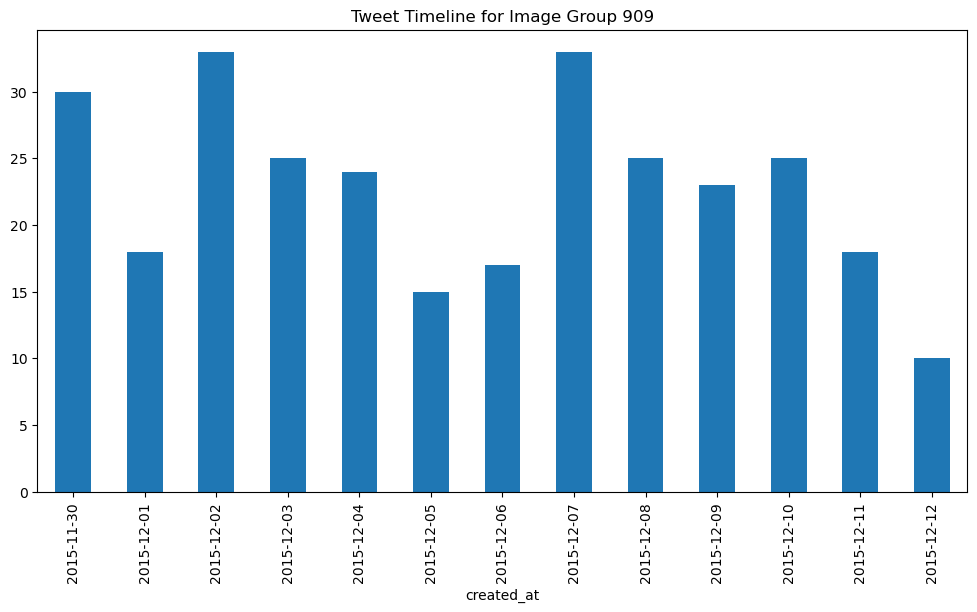

In [29]:
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])
cluster_timeline = merged_df.groupby(merged_df['created_at'].dt.date).size()
cluster_timeline.plot(kind='bar', figsize=(12, 6), title='Tweet Timeline for Image Group 909')

### Spreading / Retweets

In [30]:
merged_df['is_retweet'].value_counts()

is_retweet
False    272
True      24
Name: count, dtype: int64

### Account Types

In [31]:
merged_df['Type'].value_counts()

Type
Advocacy actors        112
Business actors         66
Private individuals     54
Political actors        28
Journalistic actors     27
Scientific actors        5
Unclear                  4
Name: count, dtype: int64

### Engagement

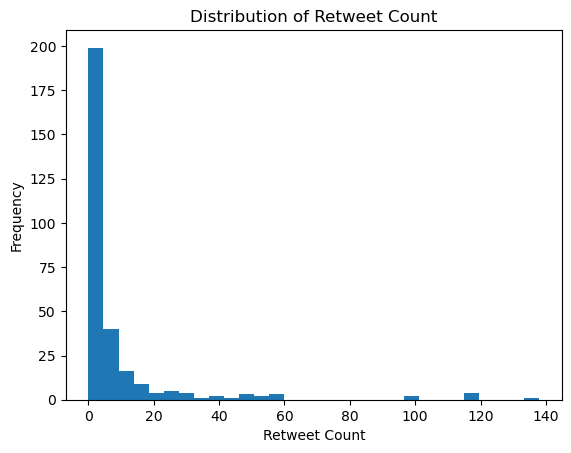

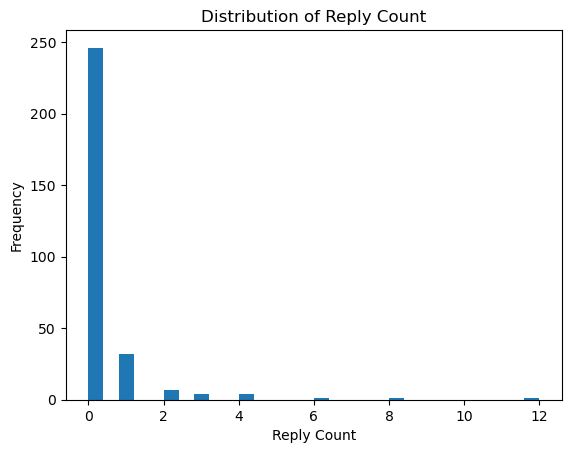

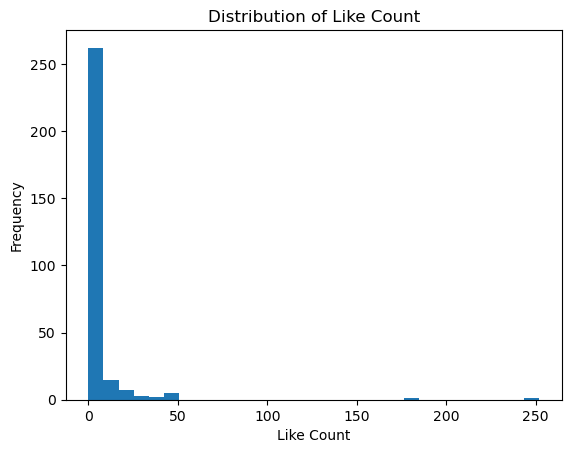

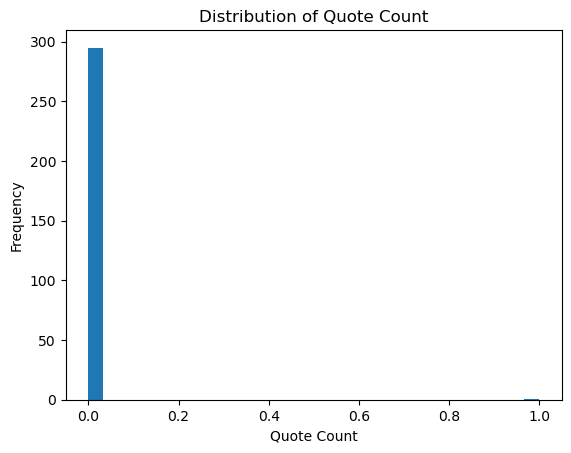

In [32]:
for metric in ["retweet_count", "reply_count", "like_count", "quote_count"]:
    plt.hist(merged_df[metric], bins=30)
    plt.title(f"Distribution of {metric.replace('_', ' ').title()}")
    plt.xlabel(metric.replace('_', ' ').title())
    plt.ylabel("Frequency")
    plt.show()

In [33]:
merged_df["public_metrics"].value_counts()

public_metrics
{'retweet_count': 0, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}       73
{'retweet_count': 1, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}       20
{'retweet_count': 0, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}       17
{'retweet_count': 2, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}       10
{'retweet_count': 1, 'reply_count': 0, 'like_count': 1, 'quote_count': 0}        9
                                                                                ..
{'retweet_count': 58, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}       1
{'retweet_count': 47, 'reply_count': 2, 'like_count': 31, 'quote_count': 0}      1
{'retweet_count': 99, 'reply_count': 12, 'like_count': 50, 'quote_count': 0}     1
{'retweet_count': 99, 'reply_count': 0, 'like_count': 0, 'quote_count': 0}       1
{'retweet_count': 9, 'reply_count': 0, 'like_count': 7, 'quote_count': 0}        1
Name: count, Length: 120, dtype: int64

In [36]:
merged_df['text'].value_counts()

text
RT @COP21_News: Alemania dice adiós a nuclear y duplica eólica, solar, biomasa ... #COP21 https://t.co/e96oikQzsM https://t.co/M1FLA4RbzC       2
We have to act now to address #climatechange.We support the grassroots initiative #Nuclear4Climate during the #COP21 https://t.co/isvXzlmYDt    2
RT @afpfr: #COP21 La plus grande centrale photovoltaïque d'Europe inaugurée en Gironde https://t.co/TMMKUcot3i #AFP https://t.co/QcFX9us0SN     2
SolutionWind #SolutionWind #COP21 https://t.co/gp7dHvvpbE https://t.co/9lF2HyVDj0                                                               1
#COP21 Climat: les négociations de Paris passent à la vitesse supérieure #AFP… https://t.co/lWWhlp3oTZ https://t.co/dolEcplmK2                  1
                                                                                                                                               ..
IEA at #COP21 today: LPAA Agenda Innovation Focus. Full schedule of IEA events at: https://t.co/rQH6kaczNI https://t.co

In [37]:
merged_df['image_file'].value_counts()

image_file
3_671804395038892033.jpg    5
3_674416755436085248.jpg    4
3_675074790084976640.jpg    4
3_674280957403205632.jpg    3
3_674170416886374405.png    3
                           ..
3_665097189052559360.jpg    1
3_672748499444752384.jpg    1
3_672347626218594304.jpg    1
3_673895572063948800.png    1
3_674702689641435136.png    1
Name: count, Length: 259, dtype: int64

In [40]:
merged_df.columns

Index(['image_file', 'group_id', 'tweet_id', 'Labels', 'btm_topic', 'tokens',
       'text_btm_str', 'author_id', 'text', 'created_at', 'lang',
       'referenced_tweets', 'public_metrics', 'attachments', 'entities',
       'Type', 'Lang', 'Stance', 'is_retweet', 'retweet_count', 'reply_count',
       'like_count', 'quote_count'],
      dtype='object')

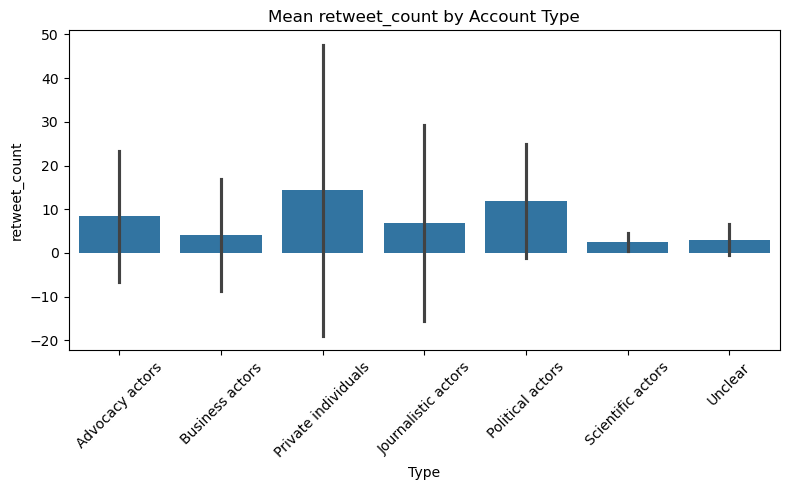

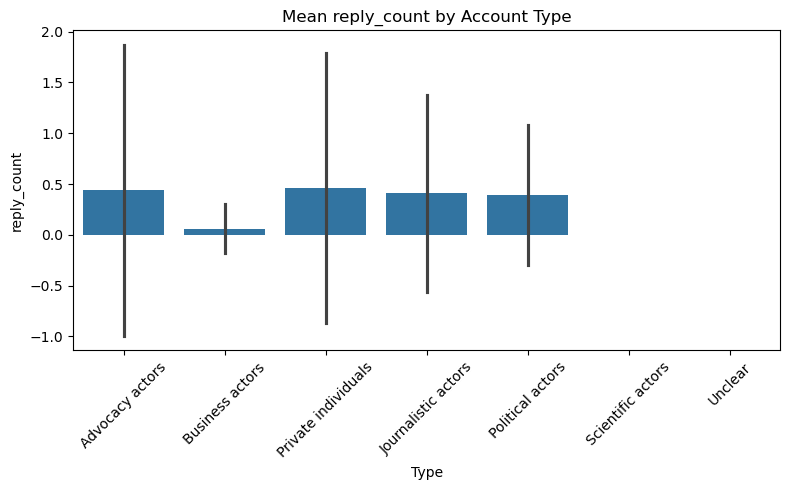

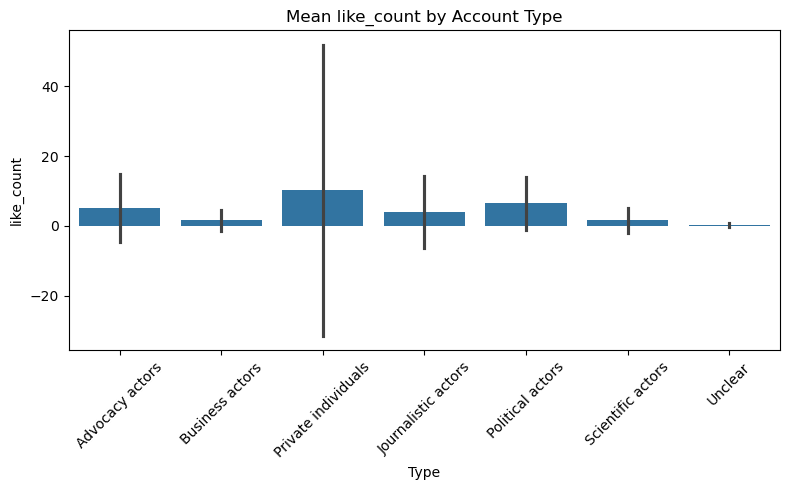

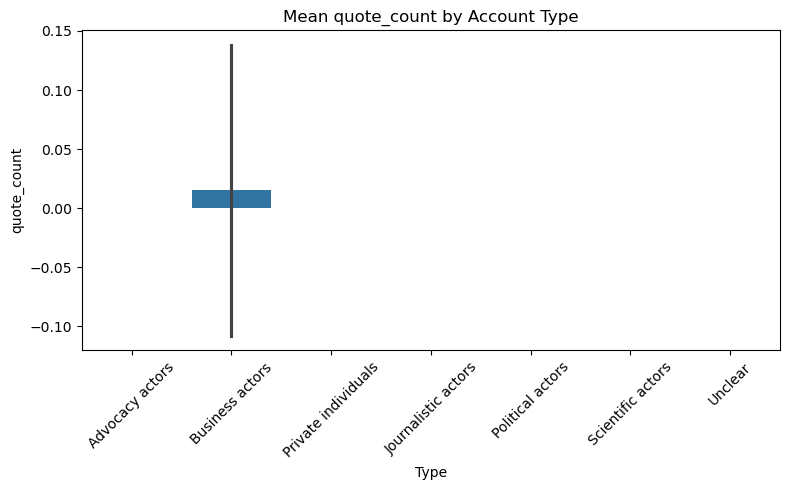

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

interaction_cols = ['retweet_count', 'reply_count', 'like_count', 'quote_count']

for col in interaction_cols:
    plt.figure(figsize=(8,5))
    sns.barplot(data=merged_df, x='Type', y=col, estimator='mean', errorbar='sd')
    plt.title(f"Mean {col} by Account Type")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
